Dataset Shape: (1966, 8)
Columns: ['author', 'published', 'title', 'text', 'language', 'label', 'title_without_stopwords', 'text_without_stopwords']
First few rows:


,author,published,title,text,language,label,title_without_stopwords,text_without_stopwords
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...


Label distribution:
label
0    0.619023
1    0.380977
Name: proportion, dtype: float64


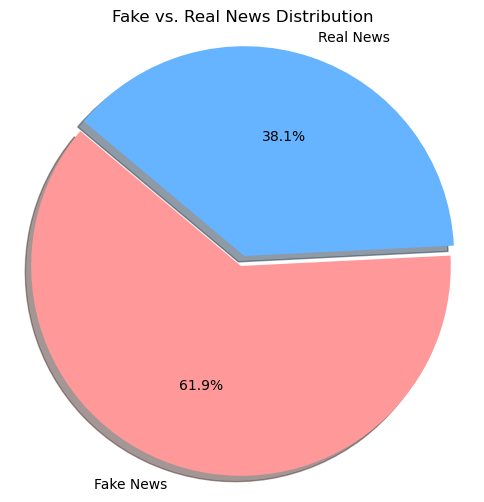

In [2]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer

# For data splitting and balancing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE

# For modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Step 2: Load the cleaned dataset
file_path = 'news_articles-1.xlsx'  # If in same directory as your notebook
df = pd.read_excel(file_path)

# Step 3: Quick check
print(f"Dataset Shape: {df.shape}")
print("Columns:", df.columns.tolist())
print("First few rows:")
display(df.head())
# Step 4: Prepare feature (X) and label (y)
X = df['text_without_stopwords']
y = df['label'].map({'Fake': 0, 'Real': 1})  # Convert labels to binary: 0 = Fake, 1 = Real

# Check class balance
print("Label distribution:")
print(y.value_counts(normalize=True))
# Step 5: Pie chart to show label distribution
import matplotlib.pyplot as plt

# Count label frequencies
label_counts = y.value_counts()
labels = ['Fake News', 'Real News']
sizes = label_counts.values
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0)  # Slightly "explode" the first slice (Fake News)

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.title('Fake vs. Real News Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()


In [4]:
# Confirm required column
assert 'title_without_stopwords' in df.columns, "Missing 'title_without_stopwords' column"

# ===========================================
# 3. Define Experiment Runner Function
# ===========================================
def run_title_split_experiment(model_name, test_size, ngram_range, min_df, max_features):
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        min_df=min_df,
        ngram_range=ngram_range,
        max_features=max_features
    )
    
    X = tfidf_vectorizer.fit_transform(df['title_without_stopwords'].astype(str))
    y = df['label'].map({'Fake': 0, 'Real': 1})  # Binary encoding

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    if model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'k-NN':
        model = KNeighborsClassifier()
    elif model_name == 'Multinomial NB':
        model = MultinomialNB()
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'Model': model_name,
        'Test Size': test_size,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1 Score': round(f1_score(y_test, y_pred), 4),
        'Min DF': min_df,
        'N-Gram Range': ngram_range,
        'Max Features': max_features
    }

# ===========================================
# 4. Define Experiment Plan
# ===========================================
title_split_experiment_plan = [
    # Decision Tree
    ('Decision Tree', 0.2, (1, 1), 5, 1000),
    ('Decision Tree', 0.3, (1, 2), 10, 3000),
    ('Decision Tree', 0.4, (1, 3), 15, 2000),
    
    # k-NN
    ('k-NN', 0.2, (1, 1), 5, 1000),
    ('k-NN', 0.3, (1, 2), 10, 3000),
    ('k-NN', 0.4, (1, 3), 15, 2000),
    
    # Multinomial NB
    ('Multinomial NB', 0.2, (1, 1), 5, 1000),
    ('Multinomial NB', 0.3, (1, 2), 10, 3000),
    ('Multinomial NB', 0.4, (1, 3), 15, 2000)
]

# ===========================================
# 5. Run Experiments
# ===========================================
title_split_results = []

for model_name, test_size, ngram_range, min_df, max_features in title_split_experiment_plan:
    result = run_title_split_experiment(
        model_name, test_size, ngram_range, min_df, max_features
    )
    title_split_results.append(result)

# ===========================================
# 6. Display Clean Results Table
# ===========================================
results_df = pd.DataFrame(title_split_results)
results_df = results_df.sort_values(by=['Model', 'Test Size'])

# Ensure all columns display in one row
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)

# Print clean table
display(results_df)

,Model,Test Size,Accuracy,Precision,Recall,F1 Score,Min DF,N-Gram Range,Max Features
0,Decision Tree,0.2,0.6802,0.5882,0.5333,0.5594,5,"(1, 1)",1000
1,Decision Tree,0.3,0.6492,0.5506,0.4356,0.4864,10,"(1, 2)",3000
2,Decision Tree,0.4,0.6480,0.5714,0.3067,0.3991,15,"(1, 3)",2000
6,Multinomial NB,0.2,0.7234,0.7356,0.4267,0.5401,5,"(1, 1)",1000
7,Multinomial NB,0.3,0.6746,0.6410,0.3333,0.4386,10,"(1, 2)",3000
8,Multinomial NB,0.4,0.6785,0.7117,0.2633,0.3844,15,"(1, 3)",2000
3,k-NN,0.2,0.6269,0.5113,0.4533,0.4806,5,"(1, 1)",1000
4,k-NN,0.3,0.6458,0.5482,0.4044,0.4655,10,"(1, 2)",3000
5,k-NN,0.4,0.6645,0.6250,0.3000,0.4054,15,"(1, 3)",2000


,Model,Test Size,Accuracy,Precision,Recall,F1 Score,Min DF,N-Gram Range,Max Features
0,Decision Tree,0.2,0.6396,0.5185,0.7467,0.6120,5,"(1, 1)",1000
1,Decision Tree,0.3,0.6542,0.5455,0.5600,0.5526,10,"(1, 2)",3000
2,Decision Tree,0.4,0.6734,0.5811,0.5133,0.5451,15,"(1, 3)",2000
6,Multinomial NB,0.2,0.6650,0.5474,0.6933,0.6118,5,"(1, 1)",1000
7,Multinomial NB,0.3,0.6593,0.5462,0.6311,0.5856,10,"(1, 2)",3000
8,Multinomial NB,0.4,0.6582,0.5492,0.5767,0.5626,15,"(1, 3)",2000
3,k-NN,0.2,0.5203,0.4306,0.8067,0.5615,5,"(1, 1)",1000
4,k-NN,0.3,0.6034,0.4819,0.5333,0.5063,10,"(1, 2)",3000
5,k-NN,0.4,0.6620,0.5535,0.5867,0.5696,15,"(1, 3)",2000


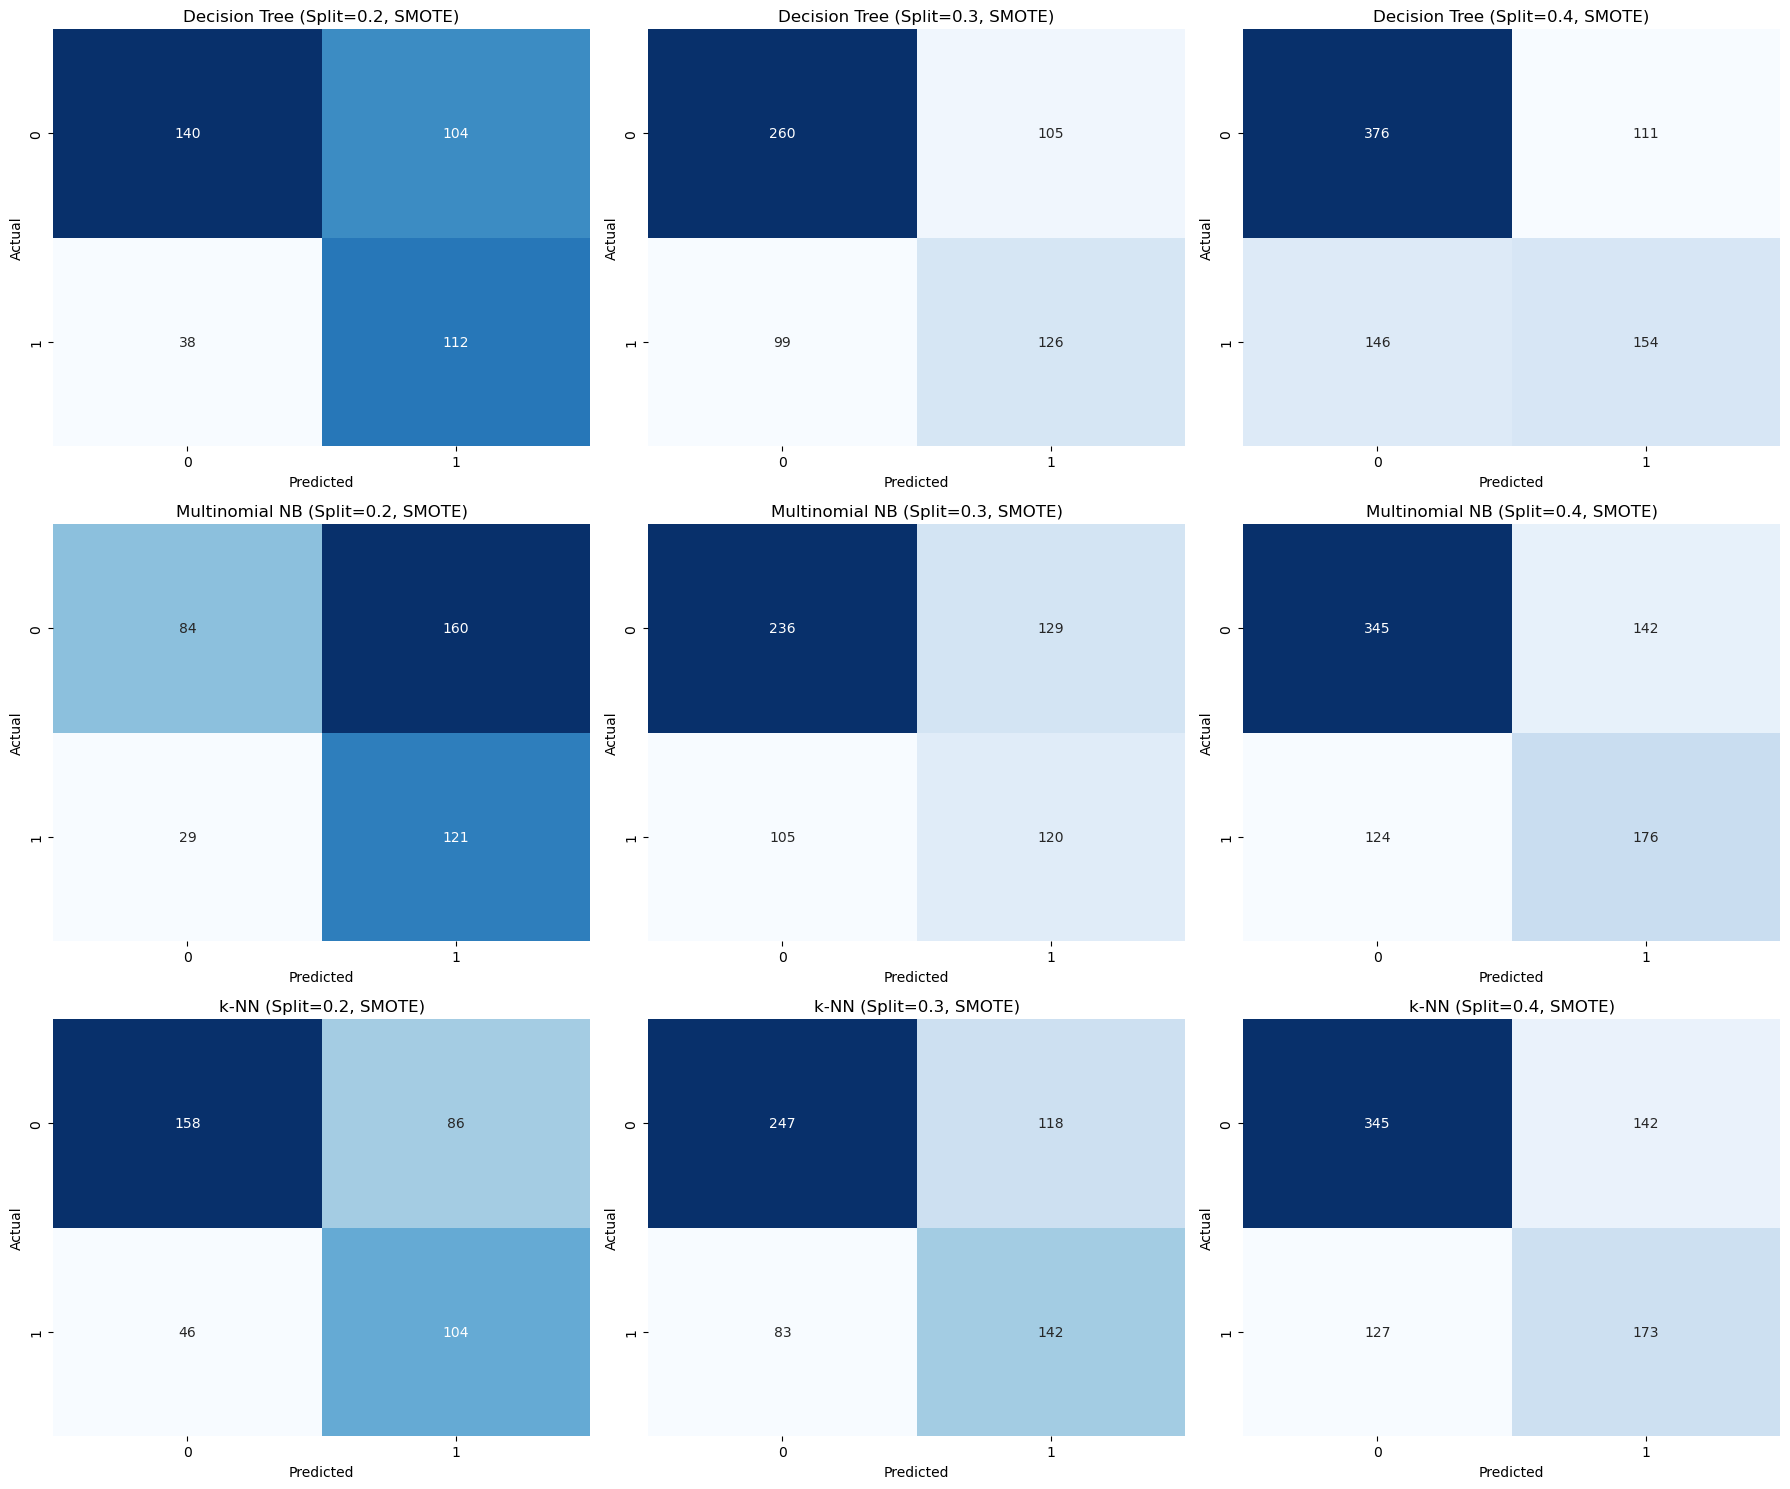

In [6]:

from imblearn.over_sampling import SMOTE

# 2. Confirm Required Column
assert 'title_without_stopwords' in df.columns, "Missing 'title_without_stopwords' column"

# 3. Define Experiment Runner Function (with SMOTE and Confusion Matrix)
def run_title_split_experiment(model_name, test_size, ngram_range, min_df, max_features):
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        min_df=min_df,
        ngram_range=ngram_range,
        max_features=max_features
    )
    
    X = tfidf_vectorizer.fit_transform(df['title_without_stopwords'].astype(str))
    y = df['label'].map({'Fake': 0, 'Real': 1})  # Binary encoding

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Apply SMOTE to training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Select model
    if model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'k-NN':
        model = KNeighborsClassifier()
    elif model_name == 'Multinomial NB':
        model = MultinomialNB()
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    # Train and predict
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'Model': model_name,
        'Test Size': test_size,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1 Score': round(f1_score(y_test, y_pred), 4),
        'Min DF': min_df,
        'N-Gram Range': ngram_range,
        'Max Features': max_features,
        'Confusion Matrix': cm
    }

# 4. Define Experiment Plan
title_split_experiment_plan = [
    # Decision Tree
    ('Decision Tree', 0.2, (1, 1), 5, 1000),
    ('Decision Tree', 0.3, (1, 2), 10, 3000),
    ('Decision Tree', 0.4, (1, 3), 15, 2000),
    
    # k-NN
    ('k-NN', 0.2, (1, 1), 5, 1000),
    ('k-NN', 0.3, (1, 2), 10, 3000),
    ('k-NN', 0.4, (1, 3), 15, 2000),
    
    # Multinomial NB
    ('Multinomial NB', 0.2, (1, 1), 5, 1000),
    ('Multinomial NB', 0.3, (1, 2), 10, 3000),
    ('Multinomial NB', 0.4, (1, 3), 15, 2000)
]

# 5. Run Experiments
title_split_results = []

for model_name, test_size, ngram_range, min_df, max_features in title_split_experiment_plan:
    result = run_title_split_experiment(
        model_name, test_size, ngram_range, min_df, max_features
    )
    title_split_results.append(result)

# 6. Display Clean Results Table
# Separate confusion matrices for plotting
confusion_matrices = [res.pop('Confusion Matrix') for res in title_split_results]

# Create DataFrame
results_df = pd.DataFrame(title_split_results)
results_df = results_df.sort_values(by=['Model', 'Test Size'])

# Display results table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)
display(results_df)

# 7. Plot Confusion Matrices
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

for idx, cm in enumerate(confusion_matrices):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"{results_df.iloc[idx]['Model']} (Split={results_df.iloc[idx]['Test Size']}, SMOTE)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

